# Capstone Project : Battle of Neighborhood Dublin(week2)
### Analyse Dublin data for business problem - IBM/Data Science Coursera

### Introduction: Business Problem
In recent years Migrations to Ireland are increased and most of the migrant are based at Dublin location. Due to increased housing prices in Dublin city area, people are preferring to locate little away from Dublin, but they find difficult to locate good restaurants or grocery store near their homes. In such scenario, restaurants like Asian, Chinese or Italian cuisine or even a grocery restaurant would be blessing for people and they won’t need to visit Dublin city centre always.

### Data
For the problem mentioned we would need data
* Location data for Dublin postal districts and greater dublin 
* Venues data around all Dublin postal districts and for Greater Dublin regions
* Also population data for 4 major regions of Dublin

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge geocoder --yes
import geocoder # import geocoder

import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
!conda install -c conda-forge folium=0.5.0 --yes

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

print('All libraries Downloaded!')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

All libraries Downloaded!


#### Get Dublin Postsal districts Location data. ALso Extract Greater dublin- Major 4 region Data from web link below,
https://en.wikipedia.org/wiki/List_of_Irish_counties_by_population


* Read url for 4 major regions of Dublin and population in Data frame

In [2]:
#Scrap data from URL for Dublin region population data
url= 'https://en.wikipedia.org/wiki/List_of_Irish_counties_by_population'
response = requests.get(url)
html = response.text
df_gdublin = pd.read_html(url)
df_gdublin = df_gdublin[0]
#Extract Greater Dublin data only
df_gdublin= df_gdublin[df_gdublin['County'].str.contains('Dublin') | df_gdublin['Rank'].str.contains('–')]
df_gdublin = (df_gdublin.drop(columns = ['Rank','Traditional province','Density (km²)','Change since previous census'])).reset_index()
df_gdublin.rename(columns={'County':'Neighborhood'}, inplace=True)
df_gdublin.drop(columns=['index'])
df_gdublin.loc[0,'Neighborhood'] = 'Dublin City'
#df_dublin.columns=['Neighborhood','Population']

In [5]:
df_gdublin.head()

,index,Neighborhood,Population
0,0,Dublin City,1347359
1,4,Fingal,296020
2,5,South Dublin,278767
3,9,Dún Laoghaire–Rathdown,218018


#### Fetch Dublin location coordinates for dublin postal districts and greater dublin areas

In [3]:
#Get locations of 4 major areas of Dublin
dublin_areas=[]
latitudes=[]
longitudes=[]
geolocator = Nominatim(user_agent="On_explorer")
#extract greater Dublin areas 
for area in df_gdublin['Neighborhood']:
    print(area)
    location = geolocator.geocode(area,timeout=20)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)
    
df_gdublin['Latitude'] = latitudes
df_gdublin['Longitude'] = longitudes
df_gdublin

Dublin City
Fingal
South Dublin
Dún Laoghaire–Rathdown


,index,Neighborhood,Population,Latitude,Longitude
0,0,Dublin City,1347359,53.349764,-6.260273
1,4,Fingal,296020,53.494221,-6.224980
2,5,South Dublin,278767,53.273260,-6.407077
3,9,Dún Laoghaire–Rathdown,218018,53.256721,-6.204865


In [4]:
#get postal district locations
latitudes=[]
longitudes=[]
districts=[]
geolocator = Nominatim(user_agent="On_explorer")
#extract greater Dublin areas 
for n in range(1, 25):
    area = 'Dublin {}'.format(n)
    districts.append(area)
    #print(area)
    location = geolocator.geocode(area, timeout=50)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

df_dublin = pd.DataFrame({'Neighborhood':districts, 'Latitude':latitudes, 'Longitude':longitudes})
df_dublin.head()


,Neighborhood,Latitude,Longitude
0,Dublin 1,53.352488,-6.256646
1,Dublin 2,53.338940,-6.252713
2,Dublin 3,53.361223,-6.185467
3,Dublin 4,53.327507,-6.227486
4,Dublin 5,53.383454,-6.181923


* Get Dublin location coordinates

In [5]:
address = 'County Dublin, Ireland'

geolocator = Nominatim(user_agent="On_explorer")
location = geolocator.geocode(address)
latitude_dublin = location.latitude
longitude_dublin = location.longitude
print('The geograpical coordinate of Dublin are {}, {}.'.format(latitude_dublin, longitude_dublin))

The geograpical coordinate of Dublin are 53.40642945, -6.287101473674747.


Define Foursquare credentials

In [6]:
#hidden cell
CLIENT_ID = 'TK02EUO5TJCWNM0OBBLZUNQGF4UAFQSAJCTAW5FEPZCKAVUW' # your Foursquare ID
CLIENT_SECRET = 'XKZAFTTF5V4LH02122JSISTXVUKB32QMNUES4LEEWJYKA5MI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

* Define Function to get venues in Dublin

In [7]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
       
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get nearby venues for neighborhood of Dublin postal districts

In [8]:
gdublin_venues= getNearbyVenues(df_gdublin['Neighborhood'],df_gdublin['Latitude'],df_gdublin['Longitude'],radius=8000)
print(gdublin_venues.shape)
gdublin_venues.head()

(400, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dublin City,53.349764,-6.260273,147 Deli,53.353410,-6.259807,Deli / Bodega
1,Dublin City,53.349764,-6.260273,Vice Coffee Inc.,53.347915,-6.262327,Coffee Shop
2,Dublin City,53.349764,-6.260273,Pull&Bear,53.349533,-6.262053,Clothing Store
3,Dublin City,53.349764,-6.260273,Vintage Cocktail Club,53.345127,-6.262851,Cocktail Bar
4,Dublin City,53.349764,-6.260273,The Winding Stair,53.346596,-6.263784,Restaurant


In [9]:
#check if duplicate venues are in data , check venue Latitude, Longitude - not same
indextodrop= gdublin_venues[gdublin_venues[['Venue Latitude','Venue Longitude']].duplicated() == True].index
print(indextodrop)
gdublin_venues.drop(index = indextodrop, inplace=True)
gdublin_venues.shape

Int64Index([390, 399], dtype='int64')


(398, 7)

In [10]:
dublin_venues= getNearbyVenues(df_dublin['Neighborhood'],df_dublin['Latitude'],df_dublin['Longitude'])
print(dublin_venues.shape)
dublin_venues.head()

(1689, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dublin 1,53.352488,-6.256646,147 Deli,53.353410,-6.259807,Deli / Bodega
1,Dublin 1,53.352488,-6.256646,Gate Theatre,53.353113,-6.261997,Theater
2,Dublin 1,53.352488,-6.256646,Holiday Inn Express Dublin City Centre Hotel,53.352306,-6.260955,Hotel
3,Dublin 1,53.352488,-6.256646,The Celt,53.350442,-6.255071,Pub
4,Dublin 1,53.352488,-6.256646,The Hop House (Kim Chi),53.352981,-6.260772,Korean Restaurant


#### Drop duplicate venues if

In [11]:
#check if duplicate venues are in data , check venue Latitude, Longitude - not same
indextodrop= dublin_venues[dublin_venues[['Venue Latitude','Venue Longitude']].duplicated() == True].index
print(indextodrop)
dublin_venues.drop(index = indextodrop, inplace=True)
dublin_venues.shape

Int64Index([ 107,  109,  110,  112,  115,  117,  119,  121,  122,  123,
            ...
            1617, 1619, 1621, 1623, 1624, 1625, 1634, 1643, 1645, 1646],
           dtype='int64', length=555)


(1134, 7)

In [12]:
#Print Unique categoeries
print("Unique category of Dublin districts venues: ", dublin_venues['Venue Category'].nunique())
print("Unique category of Greater Dublin venues: ", len(gdublin_venues['Venue Category'].unique()))

Unique category of Dublin districts venues:  188
Unique category of Greater Dublin venues:  115


 
####  Prepare data for venues analysis by postal dictricts 

In [13]:
print(dublin_venues.shape)
dublin_venues['Restaurant']=(dublin_venues['Venue Category'].str.contains('Restaurant') | dublin_venues['Venue Category'].str.contains('Hotel')).astype(int)
dublin_venues['Italian Restaurant']=(dublin_venues['Venue Category'].str.contains('Italian Restaurant')).astype(int)
dublin_venues['Cafe']=(dublin_venues['Venue Category'].str.contains('Coffee Shop') | dublin_venues['Venue Category'].str.contains('Café')).astype(int)
dublin_venues['Pub']=(dublin_venues['Venue Category'].str.contains('Pub')).astype(int)
dublin_venues['Asian']=(dublin_venues['Venue Category'].str.contains('Asian')).astype(int)
dublin_venues['Grocery Store']=(dublin_venues['Venue Category'].str.contains('Grocery Store')).astype(int)
dublin_venues.head()

(1134, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Restaurant,Italian Restaurant,Cafe,Pub,Asian,Grocery Store
0,Dublin 1,53.352488,-6.256646,147 Deli,53.353410,-6.259807,Deli / Bodega,0,0,0,0,0,0
1,Dublin 1,53.352488,-6.256646,Gate Theatre,53.353113,-6.261997,Theater,0,0,0,0,0,0
2,Dublin 1,53.352488,-6.256646,Holiday Inn Express Dublin City Centre Hotel,53.352306,-6.260955,Hotel,1,0,0,0,0,0
3,Dublin 1,53.352488,-6.256646,The Celt,53.350442,-6.255071,Pub,0,0,0,1,0,0
4,Dublin 1,53.352488,-6.256646,The Hop House (Kim Chi),53.352981,-6.260772,Korean Restaurant,1,0,0,0,0,0


#### Prepare data- Venues Analysis by Major Dublin regions

In [14]:
print(gdublin_venues.shape)
gdublin_venues['Restaurant']=(gdublin_venues['Venue Category'].str.contains('Restaurant') | gdublin_venues['Venue Category'].str.contains('Hotel')).astype(int)
gdublin_venues['Italian Restaurant']=(gdublin_venues['Venue Category'].str.contains('Italian Restaurant')).astype(int)
gdublin_venues['Cafe']=(gdublin_venues['Venue Category'].str.contains('Coffee Shop') | gdublin_venues['Venue Category'].str.contains('Café')).astype(int)
gdublin_venues['Pub']=(gdublin_venues['Venue Category'].str.contains('Pub')).astype(int)
gdublin_venues['Asian']=(gdublin_venues['Venue Category'].str.contains('Asian')).astype(int)
gdublin_venues['Grocery Store']=(gdublin_venues['Venue Category'].str.contains('Grocery Store')).astype(int)
gdublin_venues.head()

(398, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Restaurant,Italian Restaurant,Cafe,Pub,Asian,Grocery Store
0,Dublin City,53.349764,-6.260273,147 Deli,53.353410,-6.259807,Deli / Bodega,0,0,0,0,0,0
1,Dublin City,53.349764,-6.260273,Vice Coffee Inc.,53.347915,-6.262327,Coffee Shop,0,0,1,0,0,0
2,Dublin City,53.349764,-6.260273,Pull&Bear,53.349533,-6.262053,Clothing Store,0,0,0,0,0,0
3,Dublin City,53.349764,-6.260273,Vintage Cocktail Club,53.345127,-6.262851,Cocktail Bar,0,0,0,0,0,0
4,Dublin City,53.349764,-6.260273,The Winding Stair,53.346596,-6.263784,Restaurant,1,0,0,0,0,0


#### Calculate areawise restaurant count 

In [15]:
dublin_rest = dublin_venues.groupby('Neighborhood').sum().reset_index()
#dublin_rest = dublin_rest.merge(df_dublin[['Neighborhood'],  left_on='Neighborhood', right_on='Neighborhood')
dublin_rest = dublin_rest.drop(columns=['Venue Latitude','Venue Longitude'])
dublin_rest.head()

,Neighborhood,Latitude,Longitude,Restaurant,Italian Restaurant,Cafe,Pub,Asian,Grocery Store
0,Dublin 1,5335.248810,-625.664569,20,3,18,14,0,1
1,Dublin 10,3787.368375,-451.628415,13,1,5,0,2,3
2,Dublin 11,2776.103907,-327.216600,8,0,5,2,2,3
3,Dublin 12,2186.141691,-259.481790,5,1,5,2,1,4
4,Dublin 13,3096.367775,-352.372232,14,1,11,6,0,0


In [16]:
gdublin_rest = gdublin_venues.groupby('Neighborhood').sum().reset_index()
#dublin_rest = dublin_rest.merge(df_dublin[['Neighborhood'],  left_on='Neighborhood', right_on='Neighborhood')
gdublin_rest = gdublin_rest.drop(columns=['Venue Latitude','Venue Longitude'])
gdublin_rest.head()

,Neighborhood,Latitude,Longitude,Restaurant,Italian Restaurant,Cafe,Pub,Asian,Grocery Store
0,Dublin City,5334.976450,-626.027320,17,2,20,14,0,1
1,Dún Laoghaire–Rathdown,5219.158668,-608.076816,18,3,14,9,0,2
2,Fingal,5349.422125,-622.498021,25,5,18,5,0,0
3,South Dublin,5327.326035,-640.707671,24,1,11,7,1,1


#### Visualize data retrieved and derived

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

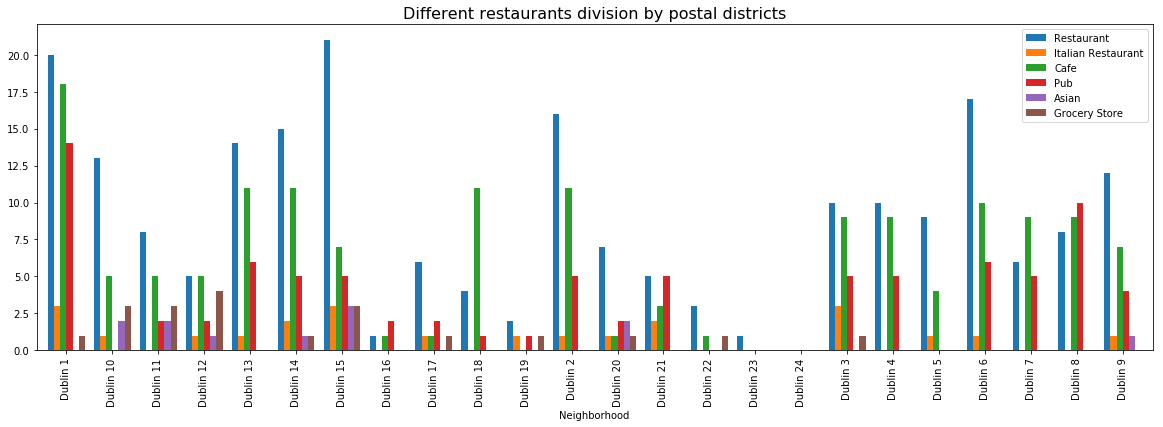

In [40]:
ax1=dublin_rest.plot(x='Neighborhood',y=['Restaurant','Italian Restaurant','Cafe','Pub','Asian','Grocery Store'], kind='bar',figsize = (20,6),
                width = 0.8)
ax1.set_title("Different restaurants division by postal districts", 
             fontsize = 16)
plt.show()

#### Plot chart for greater Dublin area

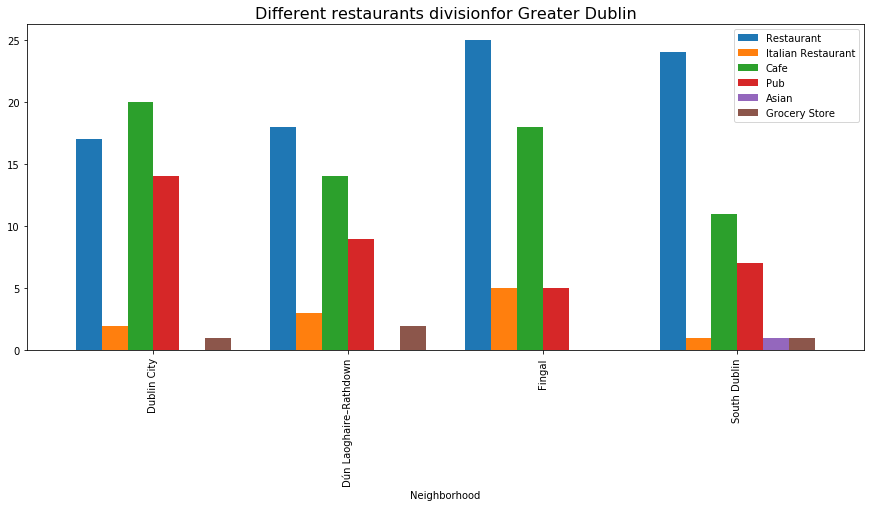

In [39]:
ax1=gdublin_rest.plot(x='Neighborhood',y=['Restaurant','Italian Restaurant','Cafe','Pub','Asian','Grocery Store'], kind='bar',figsize = (15,6),
                width = 0.8)
ax1.set_title("Different restaurants divisionfor Greater Dublin", 
             fontsize = 16)
plt.show()

#### Calculate % of restaurants areawise

In [20]:
totalrest =dublin_rest['Restaurant'].sum()
dublin_rest['rest_percent']=(dublin_rest['Restaurant']/totalrest)*100
totalgrocery = dublin_rest['Grocery Store'].sum()
dublin_rest['grocery_percent']=(dublin_rest['Grocery Store']/totalgrocery)*100
#calculate % for greater dublin
totalrest_gd=gdublin_rest['Restaurant'].sum()
gdublin_rest['rest_percent']=(gdublin_rest['Restaurant']/totalrest_gd)*100
totalgrocery = gdublin_rest['Grocery Store'].sum()
gdublin_rest['grocery_percent']=(gdublin_rest['Grocery Store']/totalgrocery)*100
dublin_rest.head()

,Neighborhood,Latitude,Longitude,Restaurant,Italian Restaurant,Cafe,Pub,Asian,Grocery Store,rest_percent,grocery_percent
0,Dublin 1,5335.248810,-625.664569,20,3,18,14,0,1,9.389671,5.0
1,Dublin 10,3787.368375,-451.628415,13,1,5,0,2,3,6.103286,15.0
2,Dublin 11,2776.103907,-327.216600,8,0,5,2,2,3,3.755869,15.0
3,Dublin 12,2186.141691,-259.481790,5,1,5,2,1,4,2.347418,20.0
4,Dublin 13,3096.367775,-352.372232,14,1,11,6,0,0,6.572770,0.0


In [21]:
gdublin_rest.head()

,Neighborhood,Latitude,Longitude,Restaurant,Italian Restaurant,Cafe,Pub,Asian,Grocery Store,rest_percent,grocery_percent
0,Dublin City,5334.976450,-626.027320,17,2,20,14,0,1,20.238095,25.0
1,Dún Laoghaire–Rathdown,5219.158668,-608.076816,18,3,14,9,0,2,21.428571,50.0
2,Fingal,5349.422125,-622.498021,25,5,18,5,0,0,29.761905,0.0
3,South Dublin,5327.326035,-640.707671,24,1,11,7,1,1,28.571429,25.0


In [22]:
#plot for population % and restauranet % for greater Dublin
totalpopulation= df_gdublin['Population'].sum()
df_gdublin['population_per']=(df_gdublin['Population']/totalpopulation)*100


In [29]:
df_gdublin=df_gdublin.merge(gdublin_rest[['Neighborhood','rest_percent','grocery_percent']], on='Neighborhood')

#### plot postal district % restaurants

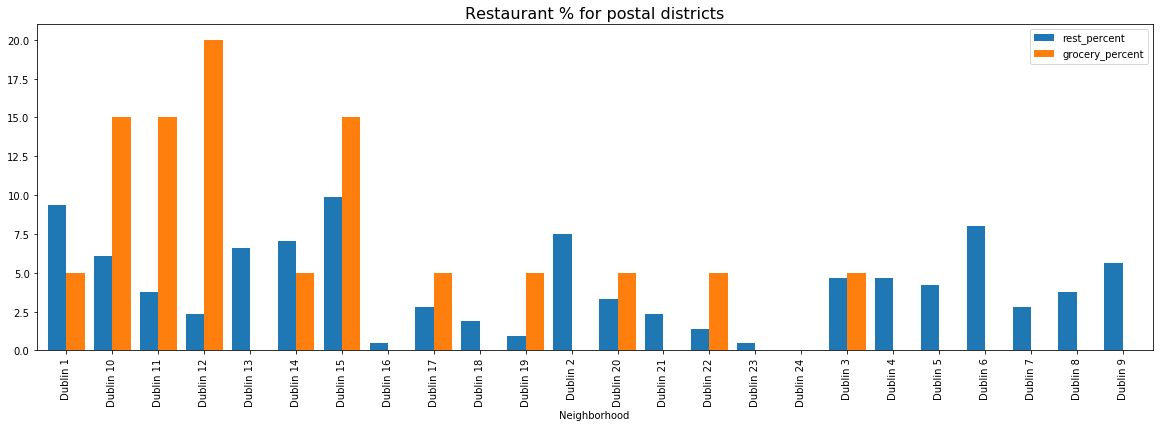

In [38]:
#plot restaurant % areawise
ax1=dublin_rest.plot(x='Neighborhood',y=['rest_percent','grocery_percent'], kind='bar',figsize = (20,6),
                width = 0.8)
ax1.set_title("Restaurant % for postal districts", 
             fontsize = 16)
plt.show()

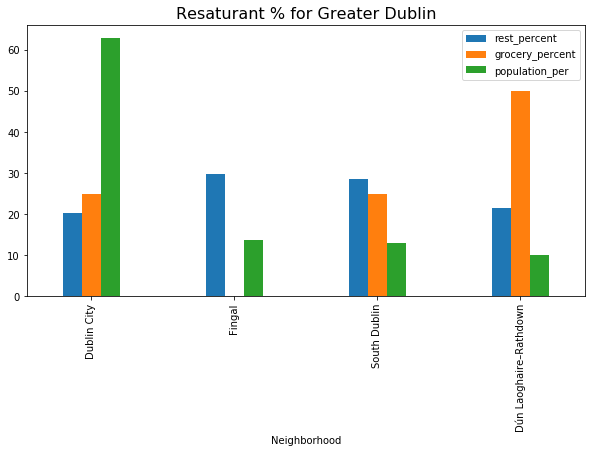

In [42]:
ax1=df_gdublin.plot(x='Neighborhood',y=['rest_percent','grocery_percent','population_per'], kind='bar',figsize = (10,5),
                width = 0.4)
ax1.set_title("Resaturant % for Greater Dublin", 
             fontsize = 16)
plt.show()

In [32]:
map_dublin = folium.Map(location=[latitude_dublin,longitude_dublin], zoom_start=10)

for lat, lon,area in zip(dublin_venues['Venue Latitude'], dublin_venues['Venue Longitude'],dublin_venues['Neighborhood']):
    folium.CircleMarker([lat, lon], radius=5, 
                        popup=area,
                        color='blue', fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)
    
map_dublin

In [30]:
# one hot encoding
dublin_onehot = pd.get_dummies(dublin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighborhood'] = dublin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_onehot.head(10)

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Boat or Ferry,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Burrito Place,Bus Stop,Café,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,English Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food & Drink Shop,Food Court,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Golf Course,Government Building,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Juice Bar,Korean Restaurant,Liquor Store,Lounge,Men's Store,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Optical Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Portuguese Restaurant,Post Office,Pub,Rafting,Record Shop,Restaurant,Rock Club,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Soccer Field,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Theme Park,Tour Provider,Toy / Game Store,Train Station,Tram Station,Turkish Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Dublin 1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### lets do onehot encoding

In [34]:
dublin_onehot = pd.get_dummies(dublin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighborhood'] = dublin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_onehot.head(10)

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Castle,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Library,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,English Restaurant,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hill,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Industrial Estate,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Portuguese Restaurant,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Ski Area,Soccer Field,Soccer Stadium,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [35]:
dublin_grouped = dublin_onehot.groupby('Neighborhood').mean().reset_index()
dublin_grouped

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Castle,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Library,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,English Restaurant,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hill,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Industrial Estate,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Portuguese Restaurant,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Ski Area,Soccer Field,Soccer Stadium,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Dublin 1,0.000000,0.000000,0.000000,0.000000,0.0100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.020000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.010000,0.000000,0.000000,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.020000,0.090000,0.01,0.010000,0.000000,0.000000,0.01,0.000000,0.010000,0.000000,0.01,0.000000,0.010000,0.01,0.000000,0.00,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.020000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.030000,0.010000,0.000000,0.000000,0.030000,0.000000,0.010000,0.00,0.000000,0.000000,0.000000,0.030000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.020000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.000000,0.020000,0.000000,0.000000,0.000000,0.140000,0.000000,0.01,0.01,0.000000,0.050000,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.010000,0.020000,0.000000,0.000000

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dublin_grouped['Neighborhood']

for ind in np.arange(dublin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dublin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dublin 1,Pub,Café,Coffee Shop,Restaurant,Theater,Ice Cream Shop,Italian Restaurant,Hotel,Burger Joint,Cocktail Bar
1,Dublin 10,Supermarket,Park,Convenience Store,Fast Food Restaurant,Hotel,Coffee Shop,Grocery Store,Bar,Chinese Restaurant,Motorcycle Shop
2,Dublin 11,Supermarket,Coffee Shop,Diner,Grocery Store,Fast Food Restaurant,Asian Restaurant,Pub,Bar,Bagel Shop,Farmers Market
3,Dublin 12,Park,Supermarket,Coffee Shop,Grocery Store,Convenience Store,Fast Food Restaurant,Bar,Shopping Mall,Pub,Asian Restaurant
4,Dublin 13,Seafood Restaurant,Café,Pub,Coffee Shop,Trail,Lighthouse,Deli / Bodega,Beach,Train Station,Golf Course


### Analysis

Overall **Italian Restaurants** are not in postal districts – **_Dublin 7,8,11,22,23_**
**_Asian Restaurants_** are not observed in **_Dublin 1, 4,6,7,8 and Fingal_** region which has plenty of restaurants and cafe otherwise.
**_Grocery stores_** are not located in **_Fingal_** area which has potential population.


### Conclusion

**_Fingal_** would be potential region to open a **Grocery store**
Assuming increasing population in **Dublin 4, Dublin 8 and Fingal region**, **_Asian restaurants_** would have good potential in these areas of Dublin 
